In [1]:
import pandas as pd

df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")


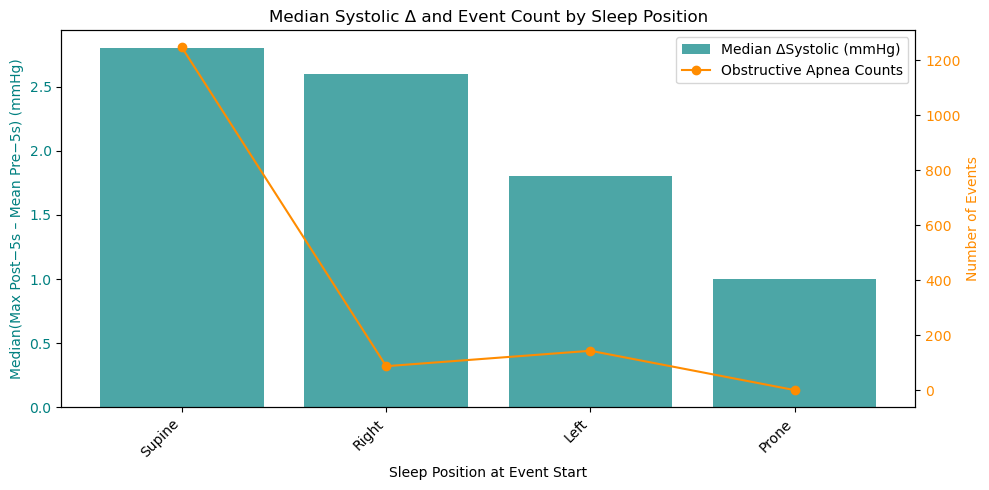

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")
# Exclude rows where Systolic_mode is "Wake" or "Movement"
#df = df[~df['Position_median'].isin(['Upright'])]

# 2. Identify Obstructive Apnea event start times and start-position for all subjects
oa_events = (
    df[df["Event name"] == "Obstructive Apnea"]
      .sort_values("Timestamp")
      .groupby(["Subject", "Rank"], as_index=False)
      .agg(
          Apnea_Start=("Timestamp", "first"),
          Position_Start=("Position_median", "first")
      )
)
oa_events = oa_events.rename(columns={"Rank": "OA_Rank"})

# 3. Compute mean pre-event & max post-event systolic per event
pre_stats = (
    df
      .merge(
          oa_events[["Subject","OA_Rank"]],
          left_on=["Subject","Pre_5"],
          right_on=["Subject","OA_Rank"],
          how="inner"
      )
      # drop zeros and exclude Upright position
      .query("Systolic_median != 0 and Position_median != 'Upright'")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Mean_Pre=("Systolic_median","mean"))
)
# post-event max
post_stats = (
    df
      .merge(oa_events[["Subject","OA_Rank"]],
             left_on=["Subject","Post_5"], right_on=["Subject","OA_Rank"],
             how="inner")
      .query("Systolic_median != 0 and Position_median != 'Upright'")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Max_Post=("Systolic_median","max"))
)


# 4. Merge into comparison DataFrame and compute difference
comparison = (
    oa_events
      .merge(pre_stats, on=["Subject","OA_Rank"])
      .merge(post_stats, on=["Subject","OA_Rank"])
)
comparison["Diff"] = comparison["Max_Post"] - comparison["Mean_Pre"]


# 5. Group by Position_Start to get median diff and event count
pos_stats = (
    comparison
      .groupby("Position_Start", as_index=False)
      .agg(
          Median_Diff = ("Diff", "median"),   # use median instead of mean
          Event_Count = ("Diff", "size")
      )
      .sort_values("Median_Diff", ascending=False)
)

# 6. Plot: dual‐axis bar (median diff) + line (event count)
fig, ax1 = plt.subplots(figsize=(10, 5))

positions = pos_stats["Position_Start"]
x = range(len(positions))

# Bar: median difference
ax1.bar(x, pos_stats["Median_Diff"], color="teal", alpha=0.7, label="Median ΔSystolic (mmHg)")
ax1.set_xlabel("Sleep Position at Event Start")
ax1.set_ylabel("Median(Max Post−5s – Mean Pre−5s) (mmHg)", color="teal")
ax1.tick_params(axis="y", labelcolor="teal")
ax1.set_xticks(x)
ax1.set_xticklabels(positions, rotation=45, ha="right")

# Line: event count on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, pos_stats["Event_Count"], color="darkorange", marker="o", label="Obstructive Apnea Counts")
ax2.set_ylabel("Number of Events", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

# Combine legends
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Median Systolic Δ and Event Count by Sleep Position")
plt.tight_layout()
plt.show()
